In this notebook, we investigate the impact of the choice of the collective variable on the free energy profile as well as the kinetics. The main conclusion of this notebook will be that the shape of the free energy profile depends on the choice of the CV (as well as for example the difference in free energy between the reactant state minimum and the transition state maximum), however, the derived kinetic rate constant (and hence also the related phenomenological free energy barrier) will not depend on this choice.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import SimpleFreeEnergyProfile, plot_profiles
from thermolib.thermodynamics.histogram import Histogram1D
from thermolib.tools import read_wham_input, blav, decorrelate
from thermolib.thermodynamics.trajectory import ColVarReader
from thermolib.thermodynamics.cv import CoordinationNumber, LinearCombination, FunctionCV
from thermolib.kinetics.rate import RateFactorEquilibrium

import numpy as np, os

from molmod.units import *

In [3]:
prefix = 'advanced_wham1D_transformations_'

# FEP and rate with original CV

We start be constructing the reference FEP in terms of the original CV, i.e. the CV along which the biasing was performed.

In [4]:
bins = np.arange(-1.7, 1.7, 0.02)
fn_meta = 'data/formic_acid_dimer_link/wham_input.txt'

In [5]:
colvar_reader = ColVarReader([0], units=['au'])
temp, biasses, trajectories = read_wham_input(
    fn_meta, colvar_reader, 'colvars/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)

We decorrelate the data using the built-in `decorrelate` routine from the `thermolib.tools` module...

/home/louis/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<Figure size 432x288 with 0 Axes>

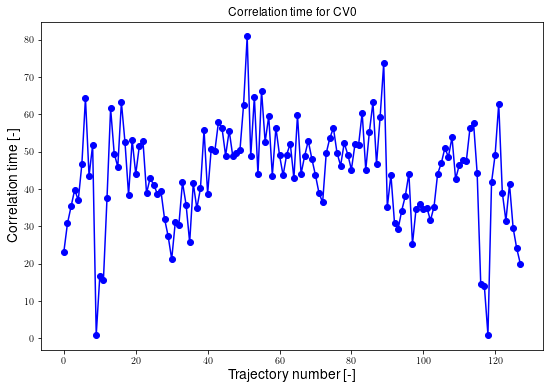

In [6]:
trajectories_decor, corrtimes = decorrelate(trajectories, fn_plot=prefix+'correlation_time.png')

...and construct the corresponding FEP

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.070s
  bias poten. : 00h 00m 00.016s
  solve scf   : 00h 00m 00.360s
  error est.  : 00h 00m 00.032s
  TOTAL       : 00h 00m 00.480s
---------------------------------------------------------------------


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


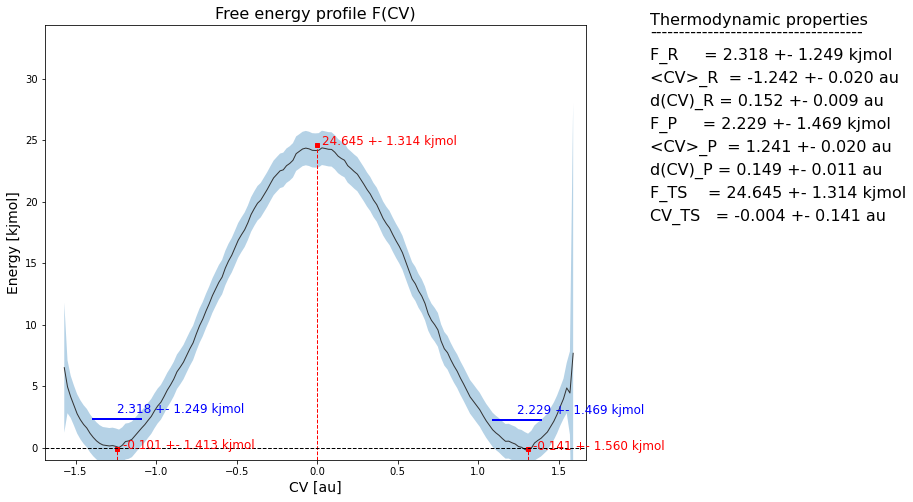

In [8]:
hist = Histogram1D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, Nscf=10000)
fep = SimpleFreeEnergyProfile.from_histogram(hist, temp=temp)
fep.process_states(lims=[-1.55,-0.2,0.2,1.55])
fep.set_ref(ref='r')
fep.plot(prefix+'fep.png')

We now also proceed by computing the rate constant according to this CV choice. For this we use all settings as discussed in the ``basic_kinetics`` tutorial.

In [9]:
#CV definition
C1 = CoordinationNumber([[0,9]], r0=1.4*angstrom)
C2 = CoordinationNumber([[7,9]], r0=1.4*angstrom)
C3 = CoordinationNumber([[2,4]], r0=1.4*angstrom)
C4 = CoordinationNumber([[5,4]], r0=1.4*angstrom)
CV = LinearCombination([C1,C2,C3,C4], [1., -1., -1., 1.])

In [10]:
CV_TS_Delta = 0.05
CV_TS_lims = [fep.ts.get_cv()-CV_TS_Delta, fep.ts.get_cv()+CV_TS_Delta]
rate = RateFactorEquilibrium(CV, CV_TS_lims, temp, CV_unit='au')

In [11]:
fn = '%s/colvars/u64.xyz' %os.path.dirname(fn_meta)
rate.process_trajectory(fn, finish=False, momenta='analytical', verbose=True)
rate.finish(fn=prefix+'rate_factor_samples.txt')

Estimating rate factor from trajectory data/formic_acid_dimer_link/colvars/u64.xyz for TS=[-0.054,0.046] au using analytical momentum integration


In [12]:
A, A_dist = rate.result_blav()

Rate factor with block averaging:
---------------------------------
  A = 17.457 +- 0.012 1e12*au/s (9191 TS samples, int. autocorr. time = 31.353 timesteps)



In [13]:
rate_results = rate.compute_rate(fep, verbose=True)

k_F  = 4.154 <= 9.768 <= 19.736 1e8/s
dF_F = 19.851 +- 1.769 kjmol
k_B  = 3.946 <= 9.671 <= 20.086 1e8/s
dF_B = 19.889 +- 1.847 kjmol


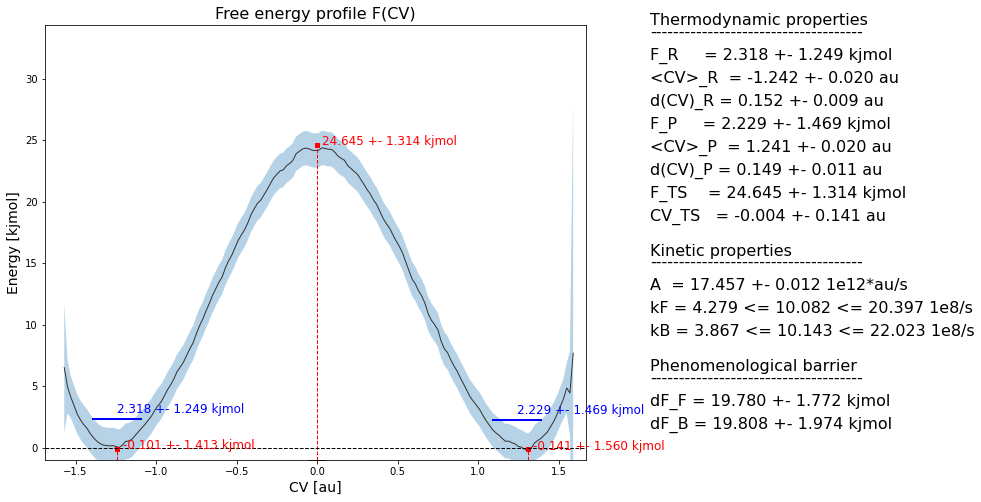

In [14]:
fep.plot(prefix+'fep_with_rate.png', rate=rate, do_latex=False)

# FEP and rate in terms of alternative CV

We are going to transform the FEP from $F(CV)$ towards $F(Q)$ with $Q=e^{0.8\cdot CV}$. This can be done using the ``transform`` routine of the BaseFreeEnergyProfile class (as well as it child class SimpleFreeEnergyProfile). For that, we first derive the transformation function as well as its derivative:

In [15]:
def function(cv):
    return np.exp(0.9*cv)/0.9

def derivative(cv):
    return np.exp(0.9*cv)

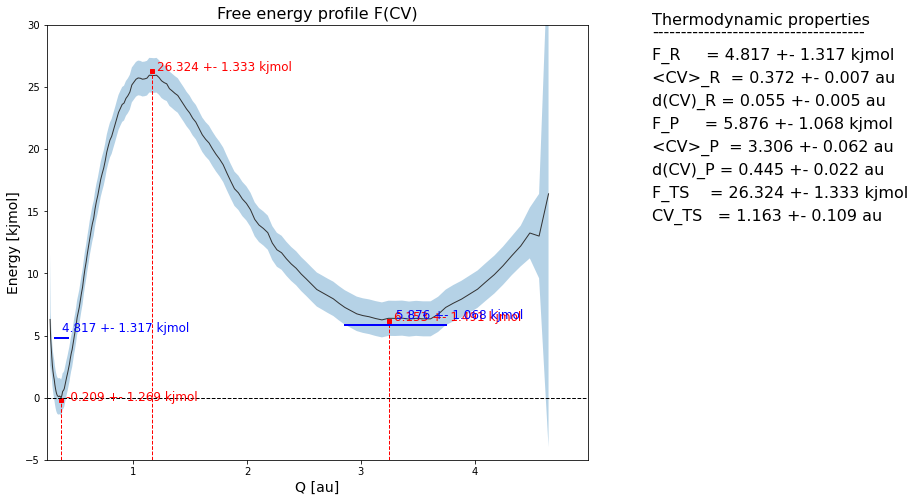

In [16]:
fep2 = fep.transform_function(function, derivative=derivative, cv_label='Q', cv_output_unit='au')
fep2.process_states(lims=[-np.inf,0.9,1.4,4.4])
fep2.set_ref(ref='r')
fep2.plot(prefix+'fep_transf.png', flims=[-5,30])

We clearly see that the free energy profile is not the same anymore as before. We now compute the rate according to the transformed CV and see if that has changed. For this, we use the CollectiveVariable child class ``FunctionCV`` to define a function of another CV:

In [17]:
Q = FunctionCV(CV, function, derivative)

We define the transition state limits for the new CV as follows:

\begin{align}
    Q_TS_lims = [Q^{TS}-dQ,Q^{TS}+dQ] \\
    dQ = \frac{dQ}{dCV}(CV^{TS})\cdot dCV
\end{align}

In [18]:
Q_TS_Delta = derivative(fep.ts.get_cv())*CV_TS_Delta
Q_TS_lims = [fep2.ts.get_cv()-Q_TS_Delta, fep2.ts.get_cv()+Q_TS_Delta]
print(Q_TS_lims)

[1.1128819103543808, 1.2125584346679694]


In [20]:
rate2 = RateFactorEquilibrium(Q, Q_TS_lims, temp, CV_unit='au')

In [21]:
fn = '%s/colvars/u64.xyz' %os.path.dirname(fn_meta)
rate2.process_trajectory(fn, finish=False, momenta='analytical', verbose=True)
rate2.finish(fn=prefix+'rate_factor_samples2.txt')

Estimating rate factor from trajectory data/formic_acid_dimer_link/colvars/u64.xyz for TS=[1.113,1.213] au using analytical momentum integration


In [22]:
A2, A2_dist = rate2.result_blav()

Rate factor with block averaging:
---------------------------------
  A = 17.843 +- 0.023 1e12*au/s (6832 TS samples, int. autocorr. time = 1.000 timesteps)



In [23]:
rate2_results = rate2.compute_rate(fep2, verbose=True)

k_F  = 6.289 <= 14.638 <= 29.371 1e8/s
dF_F = 18.929 +- 1.749 kjmol
k_B  = 10.099 <= 23.108 <= 45.832 1e8/s
dF_B = 17.887 +- 1.717 kjmol


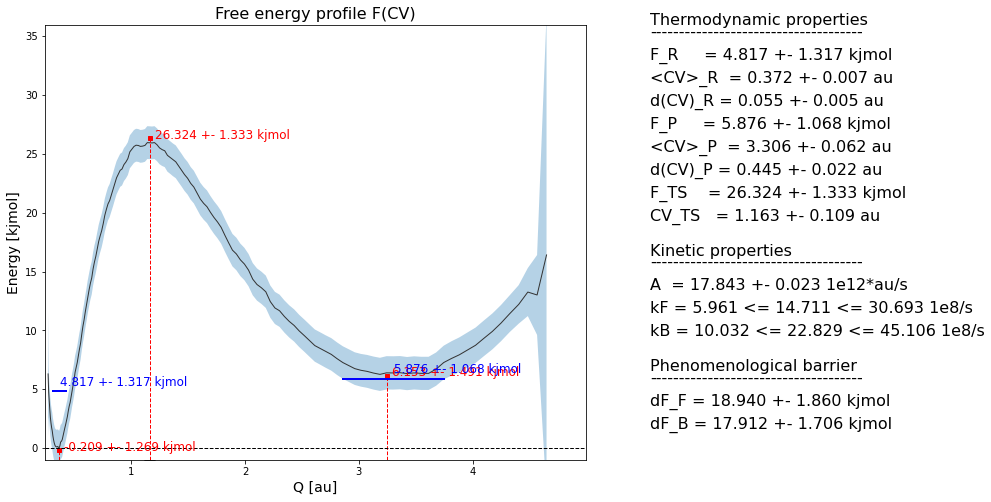

In [24]:
fep2.plot(prefix+'fep2_with_rate.png', rate=rate2, do_latex=False)

As we can see, the phenomenological barriers (both forward and backward) remain consistent with those computed with the original CV.